<a href="https://colab.research.google.com/github/takuya-tokumoto/GDL_code/blob/master/colab_pytorch/2%E7%AB%A0_%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
【README】  
- ディープラーニングによる画像認識
- Pytorchによる実装

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## データをダウンロードしてDataLoaderを構築

In [2]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## データの中身を確認



In [3]:
images, labels = next(iter(train_dl))
images[0, 0, 0, 0]

tensor(0.1373)

In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

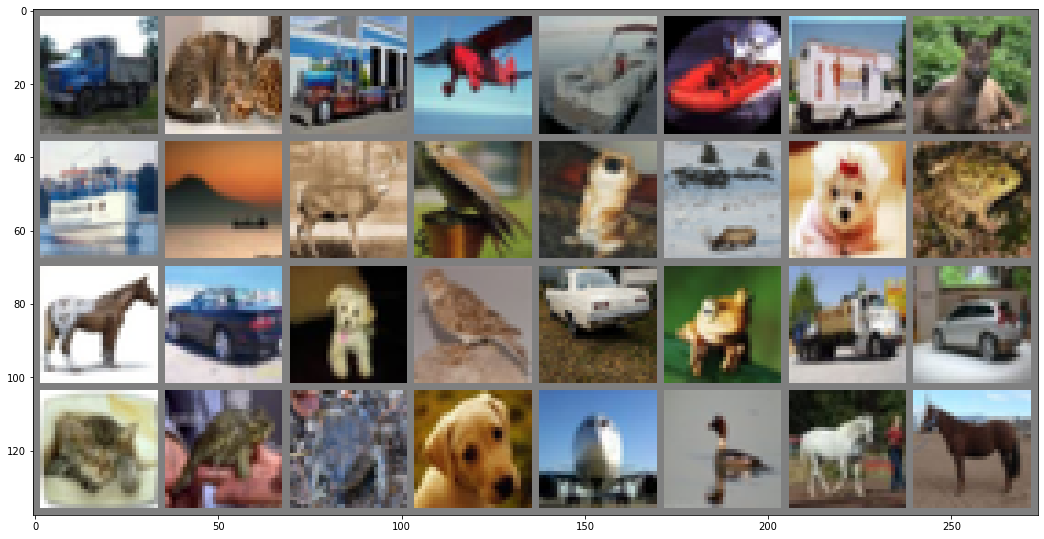

In [5]:
images, labels = next(iter(train_dl))
plt.figure(figsize=(18, 12))
imshow(torchvision.utils.make_grid(images))

## モデルを実装


In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(3072, 150)
        self.linear_2 = nn.Linear(150, 10)
    
    def forward(self, x):
        out = self.flatten(x)
        out = self.linear_1(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.relu(out)
        out = torch.softmax(out, dim=-1)
        return out

In [7]:
model = Model()
out = model(images)
out.shape

torch.Size([32, 10])

In [8]:
model

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (linear_1): Linear(in_features=3072, out_features=150, bias=True)
  (linear_2): Linear(in_features=150, out_features=10, bias=True)
)

## モデルを学習

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10
model = Model()

model.train()
model = model.to(device)

total_losses = []
with tqdm(range(epochs), total=epochs, desc='[Epoch: 00]') as epoch_iter:
    for epoch in epoch_iter:
        
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        criteria = nn.CrossEntropyLoss()
        losses = []
        with tqdm(train_dl, desc=f'[Epoch {epoch} | Batch 0000] Loss:0.000', leave=False) as batch_iter:
            for batch_idx, (images, labels) in enumerate(batch_iter):

                images = images.to(device)
                labels = labels.to(device)
                
                out = model(images)
                loss = criteria(out, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                batch_iter.set_description(f'[Epoch {epoch} | Batch {batch_idx:04d}] Loss:{loss.item():0.3f}')
                losses.append(loss.item())
            
            epoch_iter.set_description(f'[Epoch: {epoch:02d}] Train Loss: {np.mean(losses):0.3f}')
            total_losses += losses

[Epoch: 00]:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 0 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 1 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 2 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 3 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 4 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 5 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 6 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 7 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 8 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 9 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

## モデルを評価

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
outputs = []
ys = []

model.eval()
model = model.to(device)

with tqdm(test_dl, desc=f'[Batch 0000] Loss:0.000', leave=True) as batch_iter:
    for batch_idx, (images, labels) in enumerate(batch_iter):

        images = images.to(device)
        with torch.no_grad():
            out = model(images)
            outputs += [o.item() for o in out.cpu().argmax(dim=-1)]
            ys += [l.squeeze().item() for l in labels]

[Batch 0000] Loss:0.000:   0%|          | 0/313 [00:00<?, ?it/s]

In [11]:
accuracy = accuracy_score(ys, outputs)
print(f'accuracy: {accuracy:0.3f}')

accuracy: 0.472


In [12]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
output_classes = CLASSES[outputs]
actual_classes = CLASSES[ys]

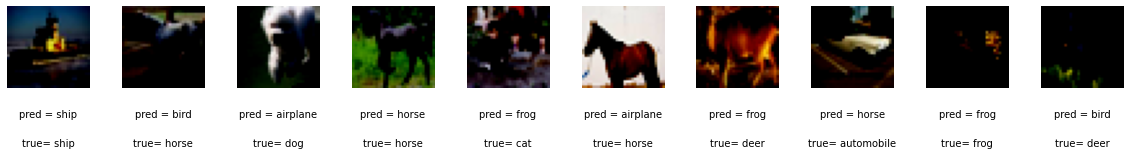

In [13]:
n_to_show = 10
indices = np.random.choice(range(len(test_ds)), n_to_show)

fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    img = img.clip(min=0.0, max=1.0).numpy()
    img = np.transpose(img, (1, 2, 0))
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(output_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'true= ' + str(actual_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

## モデルを改善する

In [14]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.batch_norm_5 = nn.BatchNorm1d(128)
        self.linear_1 = nn.Linear(65536, 128)
        self.linear_2 = nn.Linear(128, 10)
        self.leaky_relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.batch_norm_1(out)
        out = self.leaky_relu(out)

        out = self.conv_2(out)
        out = self.batch_norm_2(out)
        out = self.leaky_relu(out)

        out = self.conv_3(out)
        out = self.batch_norm_3(out)
        out = self.leaky_relu(out)
        
        out = self.conv_4(out)
        out = self.batch_norm_4(out)
        out = self.leaky_relu(out)

        out = self.flatten(out)

        out = self.linear_1(out)
        out = self.batch_norm_5(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)

        out = self.linear_2(out)
        out = torch.softmax(out, dim=-1)

        return out

In [15]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.batch_norm_5 = nn.BatchNorm1d(128)
        self.linear_1 = nn.Linear(65536, 128)
        self.linear_2 = nn.Linear(128, 10)
        self.leaky_relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.batch_norm_1(out)
        out = self.leaky_relu(out)

        out = self.conv_2(out)
        out = self.batch_norm_2(out)
        out = self.leaky_relu(out)

        out = self.conv_3(out)
        out = self.batch_norm_3(out)
        out = self.leaky_relu(out)
        
        out = self.conv_4(out)
        out = self.batch_norm_4(out)
        out = self.leaky_relu(out)

        out = self.flatten(out)

        out = self.linear_1(out)
        out = self.batch_norm_5(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)

        out = self.linear_2(out)
        out = torch.softmax(out, dim=-1)

        return out

In [16]:
model = Model2()
print(model)

images, labels = next(iter(train_dl))
out = model(images)
print(out.shape)

Model2(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_1): Linear(in_features=65536, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (flatten): Fla

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10
model = Model2()
model = model.train().to(device)

total_losses = []
with tqdm(range(epochs), total=epochs, desc='[Epoch: 00]') as epoch_iter:
    for epoch in epoch_iter:
        
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        criteria = nn.CrossEntropyLoss()
        losses = []
        with tqdm(train_dl, desc=f'[Epoch {epoch} | Batch 0000] Loss:0.000', leave=False) as batch_iter:
            for batch_idx, (images, labels) in enumerate(batch_iter):

                images = images.to(device)
                labels = labels.to(device)
                
                out = model(images)
                loss = criteria(out, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                batch_iter.set_description(f'[Epoch {epoch} | Batch {batch_idx:04d}] Loss:{loss.item():0.3f}')
                losses.append(loss.item())
            
            epoch_iter.set_description(f'[Epoch: {epoch:02d}] Train Loss: {np.mean(losses):0.3f}')
            total_losses += losses

[Epoch: 00]:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 0 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 1 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 2 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 3 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 4 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 5 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 6 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 7 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 8 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch 9 | Batch 0000] Loss:0.000:   0%|          | 0/1563 [00:00<?, ?it/s]

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
outputs = []
ys = []

model.eval()
model = model.to(device)

with tqdm(test_dl, desc=f'[Batch 0000] Loss:0.000', leave=True) as batch_iter:
    for batch_idx, (images, labels) in enumerate(batch_iter):

        images = images.to(device)
        with torch.no_grad():
            out = model(images)
            outputs += [o.item() for o in out.cpu().argmax(dim=-1)]
            ys += [l.squeeze().item() for l in labels]

[Batch 0000] Loss:0.000:   0%|          | 0/313 [00:00<?, ?it/s]

In [19]:
accuracy = accuracy_score(ys, outputs)
print(f'accuracy: {accuracy:0.3f}')

accuracy: 0.757


In [20]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
output_classes = CLASSES[outputs]
actual_classes = CLASSES[ys]

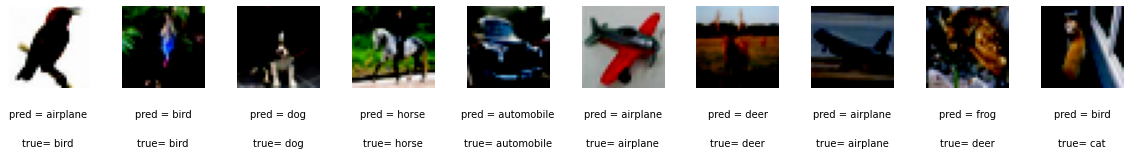

In [21]:
n_to_show = 10
indices = np.random.choice(range(len(test_ds)), n_to_show)

fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    img = img.clip(min=0.0, max=1.0).numpy()
    img = np.transpose(img, (1, 2, 0))
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(output_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'true= ' + str(actual_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)